### Chapter 2 experiments replication and coding exercises

Demonstration of Bandit classes usage

First let's rewards after 1000 steps for stationary sample-average greedy method, and plot them

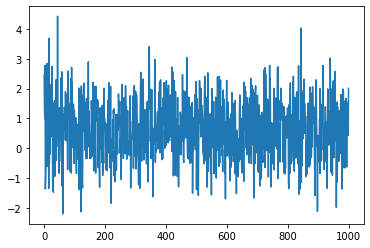

In [1]:
import matplotlib.pyplot as plt

# bandit.py contains all necessary classes
from bandit import EpsGreedy

steps = 1000
rewards = EpsGreedy(eps=0).rewards_stat(steps)
plt.plot(range(steps), rewards)

Now let's get the rewards over 2000 runs. It will take some time

In [2]:
import time

t0 = time.perf_counter()

runs = 2000
rewards = [EpsGreedy(eps=0).rewards_stat(steps) for _ in range(runs)]

t1 = time.perf_counter()
print(f'took {t1 - t0} secs')

took 11.705575488998875 secs


Use numpy to get the average reward over all runs

In [3]:
import numpy as np

rewards = np.array(rewards)
rewards.shape

(2000, 1000)

axis0 stands for runs, axis1 stands for steps. Get and plot.

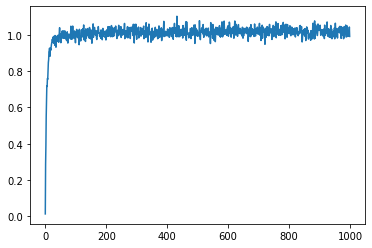

In [4]:
rewards = rewards.mean(axis=0)
plt.plot(range(steps), rewards)

Looks like the figure 2.2 from RL book.
As all experiment runs are independent, we can make use of multiprocessing. Let's compare the execution time for rewards.

In [5]:
import multiprocessing as mp

next line is needed if you run this code on linux, skip it if on windows or OS X

In [6]:
mp.set_start_method('spawn')

In [7]:
# total number of cpu threads
threads = mp.cpu_count()

t0 = time.perf_counter()

with mp.Pool(threads) as pool:
    rewards = np.array(pool.map(EpsGreedy(eps=0).rewards_stat, [steps] * runs))

t1 = time.perf_counter()
print(f'took {t1 - t0} secs')


took 2.128216004002752 secs


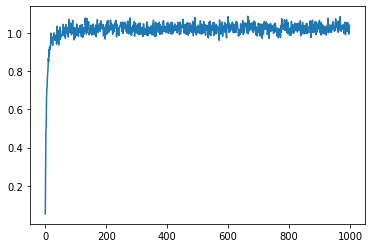

In [9]:
rewards = rewards.mean(axis=0)
plt.plot(range(steps), rewards)

Replicate figure 2.2

In [11]:
# epsilon values for greedy and epsilon-greedy methods
epsilons = (0, 0.1, 0.01)

print('Stationary greedy started...')
t0 = time.perf_counter()

with mp.Pool(mp.cpu_count()) as pool:
    # 3 epsilons, 2000 runs
    def func(x):
        # rews_opts_stat function returns tuple (reward, optimal) on each step.
        return np.array(pool.map(EpsGreedy(eps=x).rews_opts_stat, [steps] * runs))
    result = [func(eps) for eps in epsilons]

t1 = time.perf_counter()
print(f'Done in {round(t1 - t0, 3)} sec')

Stationary greedy started...
Done in 4.522 sec


got three (2000, 2, 1000)-shaped arrays, axis1 stands for rewards and optimals

In [12]:
result[0].shape

(2000, 2, 1000)

Extract rewards and optimals

In [13]:
from bandit import Bandit
# Bandit is a parent class for all bandit classes. It contains some usefull methods
# e.g. for getting percentages of optimal actions and plotting graphs

rewards = [pair[:, 0, :].mean(axis=0) for pair in result]
optimals = [Bandit.percent(pair[:, 1, :]) for pair in result]

make plots look like in the book

<AxesSubplot:xlabel='Steps', ylabel='% Optimal action'>

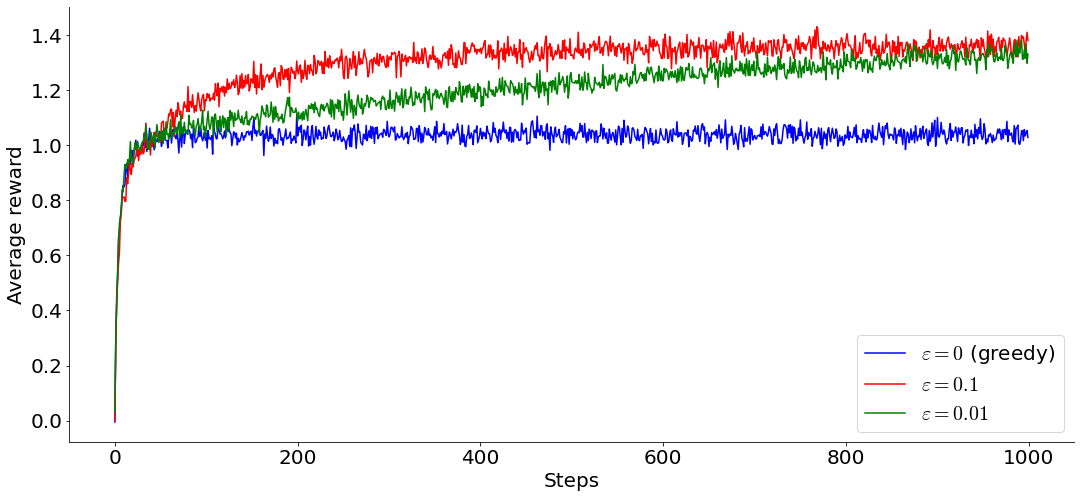

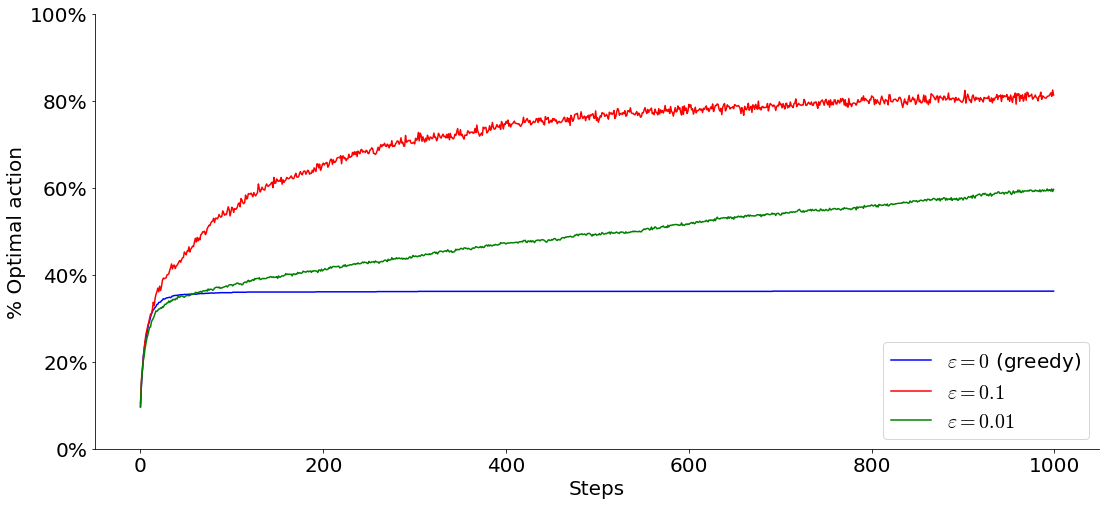

In [14]:
colors = ('green', 'blue', 'red')
labels = (r'$\varepsilon=0$ (greedy)', r'$\varepsilon=0.1$', r'$\varepsilon=0.01$')
Bandit.plot(rewards, labels, 'Average reward')
Bandit.plot(optimals, labels, '% Optimal action')

# Exercise 2.5

Start exercise 2.5... 
Done in 49.844 sec


<AxesSubplot:xlabel='Steps', ylabel='% Optimal action'>

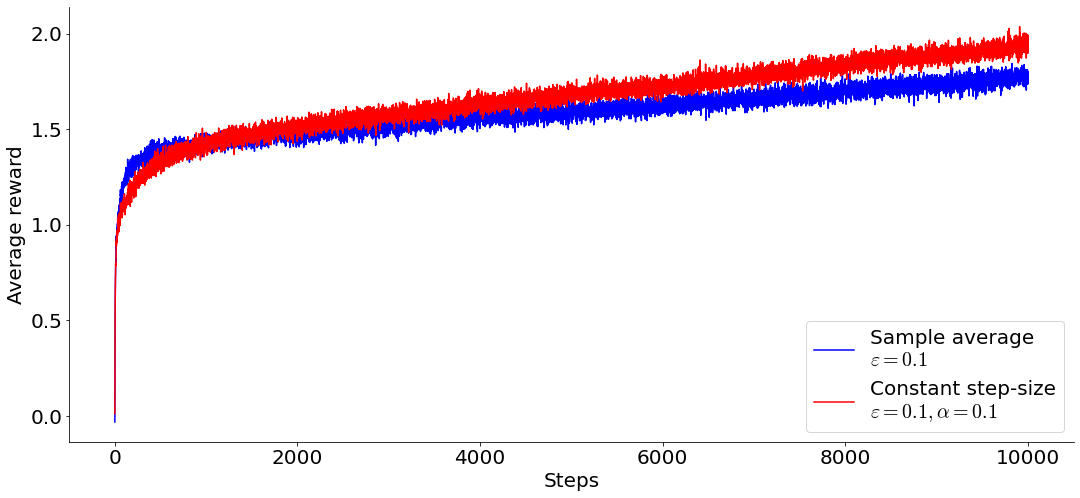

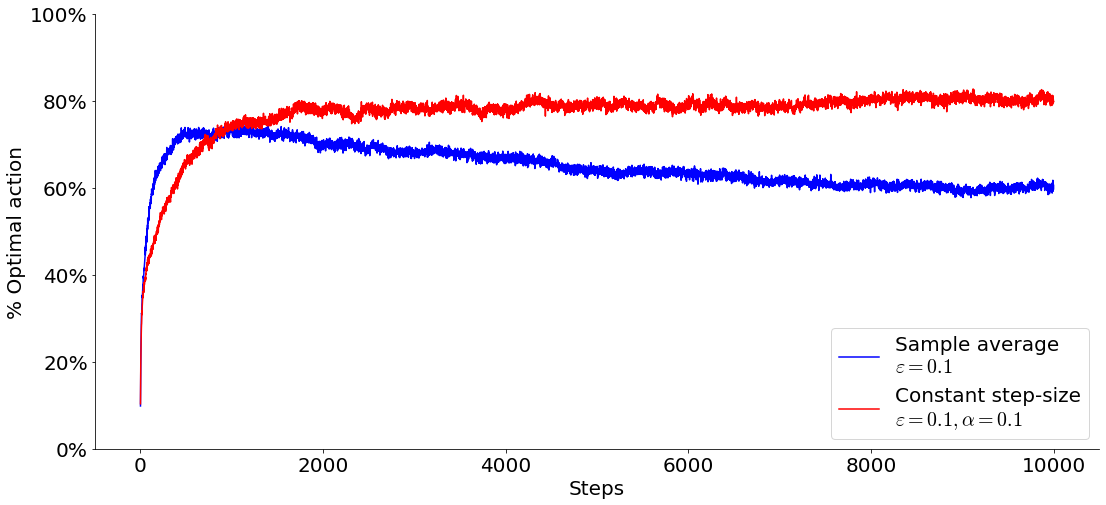

In [16]:
from bandit import EpsGreedyConstant

steps = int(1e4)
args = [steps] * runs

print('Start exercise 2.5... ')
t1 = time.perf_counter()

with mp.Pool(mp.cpu_count()) as pool:
    sample_av = np.array(pool.map(EpsGreedy(eps=0.1).rews_opts_nonstat, args))
    const_step = np.array(pool.map(EpsGreedyConstant(eps=0.1, alpha=0.1).rews_opts_nonstat, args))
    # got (2000, 2, 1000)-shaped arrays, axis=1 stands for rewards and optimals

t2 = time.perf_counter()
print(f'Done in {round(t2 - t1, 3)} sec')

# get average rewards
rewards = (sample_av[:, 0, :].mean(axis=0),
           const_step[:, 0, :].mean(axis=0))

# get optimal action percentage
optimals = (Bandit.percent(sample_av[:, 1, :]),
            Bandit.percent(const_step[:, 1, :]))

# plot
labels = ('Sample average\n' r'$\varepsilon=0.1$',
          'Constant step-size\n' r'$\varepsilon=0.1, \alpha=0.1$')
Bandit.plot(rewards, labels, 'Average reward')
Bandit.plot(optimals, labels, '% Optimal action')

# Figure 2.3

Optimistic vs realistic started...
Done in 2.987 sec


<AxesSubplot:xlabel='Steps', ylabel='% Optimal action'>

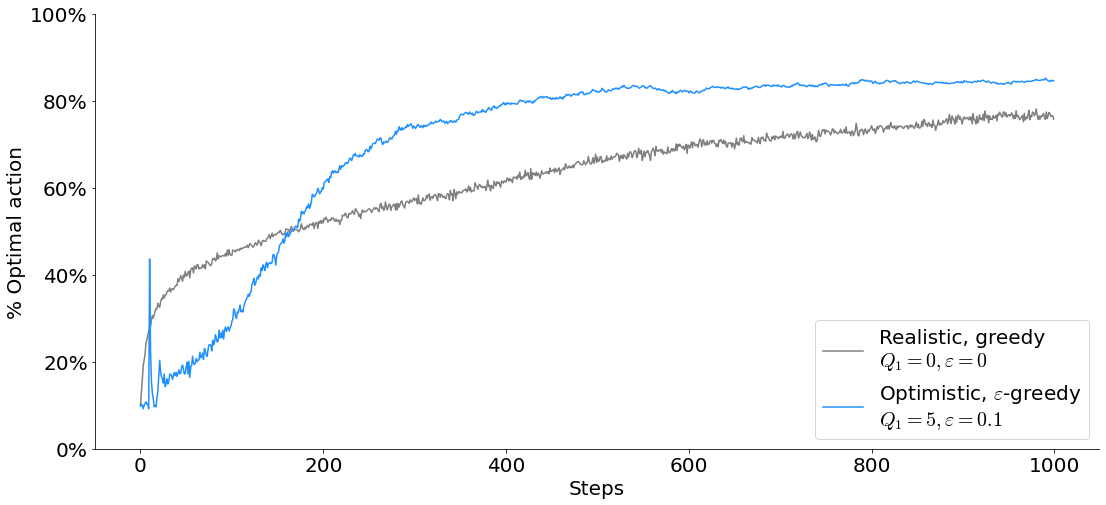

In [18]:
steps = int(1e3)
args = [steps] * runs

print('Optimistic vs realistic started...')
t1 = time.perf_counter()

with mp.Pool(mp.cpu_count()) as pool:
    realistic = (EpsGreedyConstant(eps=0.1, alpha=0.1).optimals_stat, args)
    realistic = np.array(pool.map(*realistic))
    optimistic = (EpsGreedyConstant(estim_value=5, eps=0, alpha=0.1).optimals_stat, args)
    optimistic = np.array(pool.map(*optimistic))

t2 = time.perf_counter()
print(f'Done in {round(t2 - t1, 3)} sec')

# percentage of optimal actions
realistic = Bandit.percent(realistic)
optimistic = Bandit.percent(optimistic)

# plotting
labels = ('Realistic, greedy\n' r'$Q_1=0, \varepsilon=0$',
          r'Optimistic, $\varepsilon$-greedy' '\n' r'$Q_1=5, \varepsilon=0.1$')

Bandit.plot((realistic, optimistic), labels, '% Optimal action', colors=('grey', 'dodgerblue'))

# Figure 2.4

Start upper confidence bound...
Done in 3.919 sec


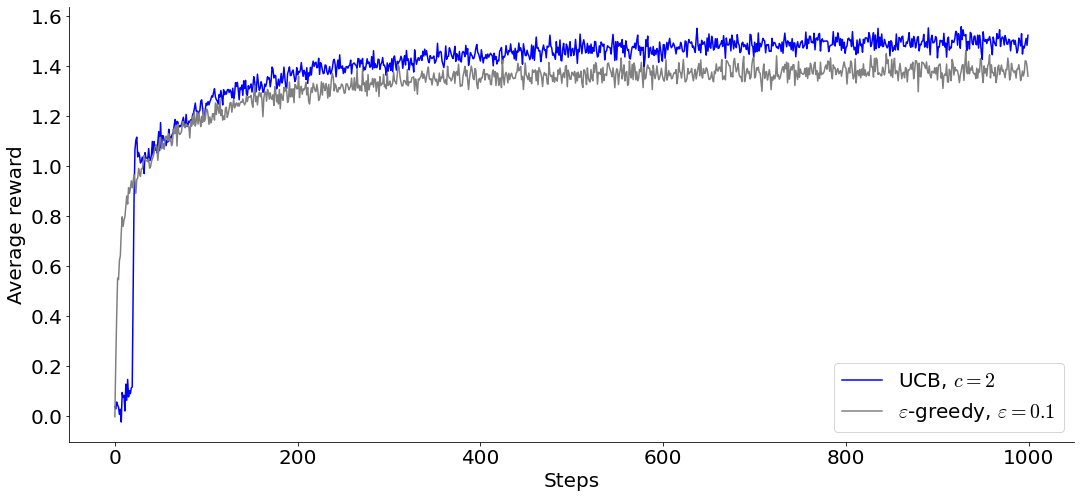

In [19]:
from bandit import UCB

print('Start upper confidence bound...')
t1 = time.perf_counter()

with mp.Pool(mp.cpu_count()) as pool:
    ucb = np.array(pool.map(UCB(c=2).stationary, args))[:, 0, :]
    greedy = np.array(pool.map(EpsGreedy(eps=0.1).stationary, args))[:, 0, :]

t2 = time.perf_counter()
print(f'Done in {round(t2 - t1, 3)} sec')

# get the averages
ucb = ucb.mean(axis=0)
greedy = greedy.mean(axis=0)

# plot
labels = (r'UCB, $c=2$',
          r'$\varepsilon$-greedy, $\varepsilon=0.1$')
Bandit.plot((ucb, greedy), labels, 'Average reward', colors=('blue', 'grey'))

plt.show()

# Fig 2.5

Started gradient bandit...
Done in 8.039 sec


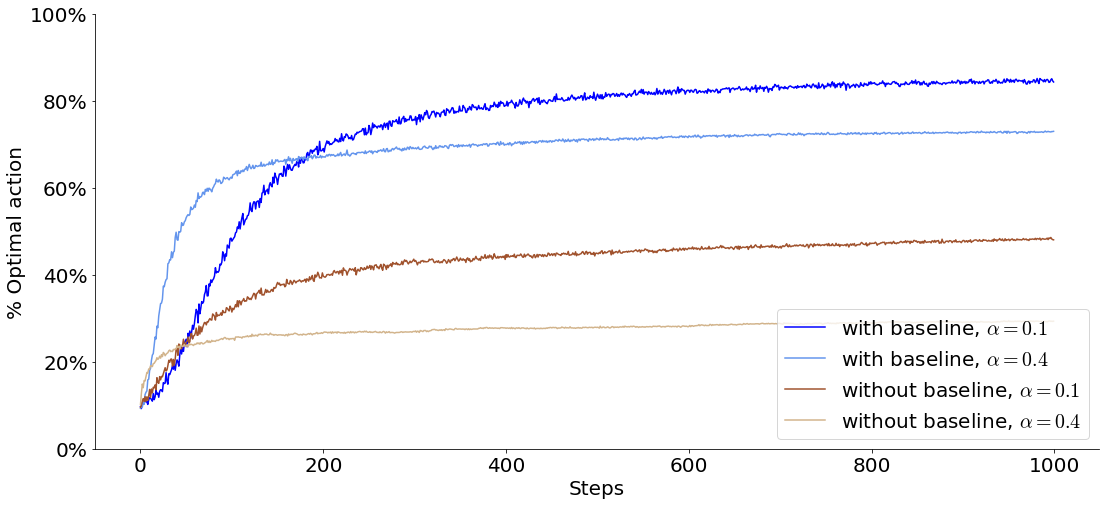

In [21]:
from bandit import GradientNoBaseline, GradientBaseline

print('Started gradient bandit...')
t1 = time.perf_counter()

with mp.Pool(mp.cpu_count()) as pool:
    bl01 = np.array(pool.map(GradientBaseline(true_value=4, alpha=0.1).optimals_stat, args))
    bl04 = np.array(pool.map(GradientBaseline(true_value=4, alpha=0.4).optimals_stat, args))
    no_bl01 = np.array(pool.map(GradientNoBaseline(true_value=4, alpha=0.1).optimals_stat, args))
    no_bl04 = np.array(pool.map(GradientNoBaseline(true_value=4, alpha=0.4).optimals_stat, args))

t2 = time.perf_counter()
print(f'Done in {round(t2 - t1, 3)} sec')

result = [bl01, bl04, no_bl01, no_bl04]
# get percentages
result = [Bandit.percent(i) for i in result]

# plotting
labels = (r'with baseline, $\alpha=0.1$',
          r'with baseline, $\alpha=0.4$',
          r'without baseline, $\alpha=0.1$',
          r'without baseline, $\alpha=0.4$')
colors = ('blue', 'cornflowerblue', 'sienna', 'tan')

Bandit.plot(result, labels, '% Optimal action', colors=colors)
plt.show()

# Figure 2.6

eps_greedy started with parameters:
1/128 1/64 1/32 1/16 1/8 1/4 done in 7.251 sec
grad_bline started with parameters:
1/32 1/16 1/8 1/4 1/2 1 2 4 done in 14.257 sec
ucb started with parameters:
1/16 1/8 1/4 1/2 1 2 4 done in 11.181 sec
optimistic_greedy started with parameters:
1/4 1/2 1 2 4 done in 4.884 sec
Overall execution time 37.573 sec


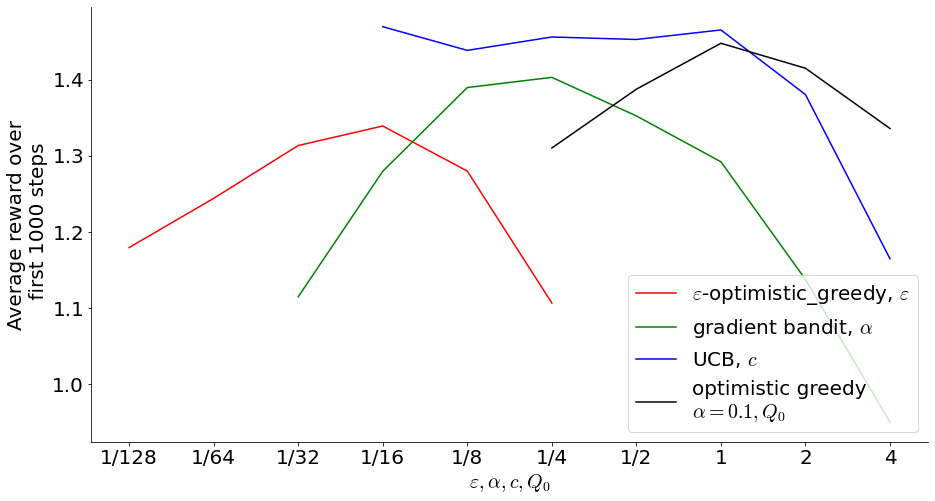

In [26]:
from collections import defaultdict

# parameter values (powers of 2)
params = [2 ** i for i in range(-7, 3)]
# string representations for parameter values
x_ticks = ['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4']
# indices for the slices of parameter values

def methods(x):
    return {'eps_greedy': EpsGreedy(eps=x).rewards_stat,
            'grad_bline': GradientBaseline(alpha=x).rewards_stat,
            'ucb': UCB(c=x).rewards_stat,
            'optimistic_greedy': EpsGreedyConstant(eps=0, alpha=0.1, estim_value=x).rewards_stat}
param_slices = {'eps_greedy': (0, 6),
                'grad_bline': (2, 11),
                'ucb': (3, 11),
                'optimistic_greedy': (5, 11)}
# dictionary to store obtained reward values for particular method
rewards = defaultdict(list)

# parallel execution
with mp.Pool(mp.cpu_count()) as pool:
    t0 = time.perf_counter()
    for method, _slice in param_slices.items():

        print(f'{method} started with parameters:')
        t1 = time.perf_counter()

        (start, stop) = _slice
        for param, x in zip(params[start:stop], x_ticks[start:stop]):
            print(f'{x}', end=' ')
            # mean reward over all runs
            arr = np.array(pool.map(methods(param)[method], args)).mean(axis=0)
            # mean reward over all steps
            rewards[method].append(arr.mean())

        t2 = time.perf_counter()
        print(f'done in {round(t2 - t1, 3)} sec')

    t3 = time.perf_counter()
    print(f'Overall execution time {round(t3 - t0, 3)} sec')

# plotting
# labels and colors
labels = (r'$\varepsilon$-optimistic_greedy, $\varepsilon$',
          r'gradient bandit, $\alpha$',
          r'UCB, $c$',
          'optimistic greedy\n' r'$\alpha=0.1, Q_0$')

ylabel = 'Average reward over\n first 1000 steps'
xlabel = r'$\varepsilon, \alpha, c, Q_0$'
colors = ('red', 'green', 'blue', 'black')

# x axis values to correspond with parameter slices
x = [list(range(10)[start:stop]) for (start, stop) in param_slices.values()]
# plots
ax = Bandit.plot(rewards.values(), labels, ylabel, datax=x, xlabel=xlabel, colors=colors, fig_size=(15, 8))
plt.xticks(range(10), x_ticks)

plt.show()

Not exactly the same, but looks very much alike))

# Exercise 2.11

Below goes the code for parameter study exercise for 200 000 steps. It takes several hours.

Here is the plot that I got

<img src="ex2.11.svg">